# **DACON-GAS**

## **Default Setting**

In [96]:
import torch
import transformers

import copy
import itertools
import json
import os
import pprint
import random
import re

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from pathlib import Path
from tqdm import tqdm

print("[VERSION]")
print(f"torch: {torch.__version__}")
print(f"transformers: {transformers.__version__}")

[VERSION]
torch: 1.10.0
transformers: 4.11.3


In [9]:
class HParams(object):
    def __init__(self):
        ## Path.
        self.data = Path("data") ## 문서요약 텍스트
        
        self.tr_data = self.data / Path("tr")
        self.tr_law_data = self.tr_data / Path("tr_law_data.json")
        self.tr_journal_data = self.tr_data / Path("tr_journal_data.json")
        self.tr_article_data = self.tr_data / Path("tr_article_data.json")

        self.vl_data = self.data / Path("vl")
        self.vl_law_data = self.vl_data / Path("vl_law_data.json")
        self.vl_journal_data = self.vl_data / Path("vl_journal_data.json")
        self.vl_article_data = self.vl_data / Path("vl_article_data.json")
        
        self.ts_data = self.data / Path("ts")
        self.ts_all_data = self.ts_data / Path("test.jsonl")
        self.ts_sample_submission = self.ts_data / Path("sample_submission.csv")

        ## Seed.
        self.seed = 42
        
        ## Dataloader
        self.tokenizer_name = "beomi/KcELECTRA-base"
        self.pt_path = self.data
        self.max_cls_len = 83 ## only 83 sentences are allowed.
        
        self.per_replica_batch_size = 32 ## multiple of 8
        self.global_batch_size = self.per_replica_batch_size * torch.cuda.device_count() ## 32
        self.num_workers = 4
        
        ## Modeling.
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        ## Transformer Decoder.
        self.d_model = 768
        self.nhead = 12
        self.dropout = 0.1
        
        self.num_layers = 2
        
        
args = HParams()
pprint.PrettyPrinter(indent=4, sort_dicts=False).pprint(vars(args))

{   'data': PosixPath('data'),
    'tr_data': PosixPath('data/tr'),
    'tr_law_data': PosixPath('data/tr/tr_law_data.json'),
    'tr_journal_data': PosixPath('data/tr/tr_journal_data.json'),
    'tr_article_data': PosixPath('data/tr/tr_article_data.json'),
    'vl_data': PosixPath('data/vl'),
    'vl_law_data': PosixPath('data/vl/vl_law_data.json'),
    'vl_journal_data': PosixPath('data/vl/vl_journal_data.json'),
    'vl_article_data': PosixPath('data/vl/vl_article_data.json'),
    'ts_data': PosixPath('data/ts'),
    'ts_all_data': PosixPath('data/ts/test.jsonl'),
    'ts_sample_submission': PosixPath('data/ts/sample_submission.csv'),
    'seed': 42,
    'tokenizer_name': 'beomi/KcELECTRA-base',
    'pt_path': PosixPath('data'),
    'per_replica_batch_size': 32,
    'global_batch_size': 32,
    'num_workers': 4,
    'device': device(type='cuda'),
    'd_model': 768,
    'nhead': 12,
    'dropout': 0.1,
    'num_layers': 2}


In [3]:
!nvidia-smi; free -h

Tue Nov  2 15:11:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 470.74       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0A:00.0  On |                  N/A |
|  0%   42C    P8    25W / 220W |    420MiB /  7979MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **Prepare Dataset**

### **Naming**

제공받은 데이터세트의 이름을 조금 변경했습니다.

In [4]:
# !tree -alh

### **Data Format**

참조: https://aihub.or.kr/aidata/8054

In [4]:
def print_tr_sample(sample: dict) -> None:
    tmp = copy.deepcopy(sample)
    tmp["documents"] = [tmp["documents"][0], tmp["documents"][-1]]
    pprint.PrettyPrinter(indent=4, sort_dicts=False).pprint(tmp)

## Print sample.
with open(args.tr_law_data, "r") as f:
    sample = json.loads(f.read())
    
print_tr_sample(sample)

{   'name': '법률문서 프로젝트',
    'delivery_date': '2020-12-23 17:23:13',
    'documents': [   {   'id': '100004',
                         'category': '일반행정',
                         'size': 'small',
                         'char_count': 377,
                         'publish_date': '19841226',
                         'title': '부당노동행위구제재심판정취소',
                         'text': [   [   {   'index': 0,
                                             'sentence': '원고가 소속회사의 노동조합에서 분규가 '
                                                         '발생하자 노조활동을 구실로 정상적인 '
                                                         '근무를 해태하고,',
                                             'highlight_indices': ''},
                                         {   'index': 1,
                                             'sentence': '노조조합장이 사임한 경우,',
                                             'highlight_indices': ''},
                                         {   'index': 2,
                                   

In [5]:
def print_ts_sample(sample: list) -> None:
    tmp = copy.deepcopy(sample)
    tmp = [tmp[0], tmp[-1]]
    pprint.PrettyPrinter(indent=4, sort_dicts=False).pprint(tmp)

## Print sample.
with open(args.ts_all_data, "r") as f:
    sample = [json.loads(line) for line in f]
    
print_ts_sample(sample)

[   {   'id': '368851881',
        'article_original': [   '한국은행이 지난달 기준금리를 추가 인하한 영향으로 대출금리가 일제 하락했다.',
                                '특히 기업대출금리는 1996년 관련 통계 집계 이후 가장 낮은 수준까지 하락했다.',
                                "한국은행이 28일 발표한 '2019년 10월 중 금융기관 가중평균금리'에 따르면 "
                                '신규취급액 기준 지난달 예금은행의 대출평균금리는 연 3.20%로 전월 대비 '
                                '0.11%포인트 하락했다.',
                                '대출금리를 기업과 가계로 나눠보면 기업대출금리 하락폭이 가팔랐다.',
                                '10월 기업대출금리는 연 3.28%로 전월 대비 0.14%포인트 떨어졌다.',
                                '연 3.28%는 1996년 1월 관련 통계 작성 이후 최저치다.',
                                '대기업의 경우 기준이 되는 단기지표 금리의 하락 영향으로 10월 대출금리가 연 '
                                '3.13%로 전월 대비 0.17%포인트 빠졌다.',
                                '중소기업은 일부 은행의 저금리 대출 취급 등의 영향으로 연 3.39%로 '
                                '0.11%포인트 하락했다.',
                                '한은 관계자는 "지난달 기준금리가 인하되면서 단기 지표에 영향을 많이 받는 '
                                '기업대출 금리도 역대

### **Fix Seed**

In [4]:
def seed_everything(seed: int = args.seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
    
seed_everything()

### **DataLoader**

In [37]:
class TrainDataset(torch.utils.data.Dataset):
    
    def __init__(
        self, 
        mode: str,
        data_path: Path, 
        pt_path: Path = args.pt_path,
        sample_submission_path: Path = args.ts_sample_submission,
        vocab_size: int = 512,
        inp_pad_id: int = 0,
        cls_pad_id: int = -1,
        seg_pad_id: int = 0,
        debug: bool = False,
    ):
        if not (mode in ["tr", "vl", "ts"]):
            raise AssertionError(f"Mode must be the one of 'tr', 'vl', or 'ts': not {mode}")
        self.mode = mode
        
        self.data_path = data_path
        self.pt_path = pt_path
        self.sample_submission_path = sample_submission_path
        self.vocab_size = vocab_size ## maximum embedding length
        self.inp_pad_id = inp_pad_id
        self.cls_pad_id = cls_pad_id
        self.seg_pad_id = seg_pad_id
        self.debug = debug
        
        self.dummy_tar_ext = np.array([0, 1, 2])
        self.dummy_tar_abs = np.array([2, 3])
        
        self.tokenizer = transformers.AutoTokenizer.from_pretrained(args.tokenizer_name)
        self.df = self._data_loader() ## dataframe format
        
        
    def _get_documents(self, data_path: Path) -> list:
        print(f"Loading json data in {data_path}:")
        
        documents = []

        ## If training and validation phase...
        if self.mode in ["tr", "vl"]:
            for file_path in sorted(list(data_path.glob("*.json"))):
                print(f"  - {file_path}...")
                with open(file_path, "r", encoding="utf-8") as f:
                    document = json.loads(f.read()) ## list type -> not append, but extent
                documents.extend(document["documents"])
                
        ## If test phase...
        elif self.mode in ["ts"]:
            for file_path in sorted(list(data_path.glob("*.jsonl"))):
                print(f"  - {file_path}...")
                with open(file_path, "r", encoding="utf-8") as f:
                    documents.extend([json.loads(line) for line in f])

        return documents
                      
        
    def _data_loader(self) -> dict:
        ## Check if the dataset already constructed or not.
        df_name = Path(self.pt_path, f"{self.mode}_df.pt")
        
        if df_name.is_file():
            print(f"Preprocessed dataframe is already exist: loading {df_name}...")
            df = pd.DataFrame(torch.load(df_name))
        
        else:
            print(f"Preprocessed dataframe is not exist: constructing {df_name}...")
            documents = self._get_documents(self.data_path)
            df = self._construct_dataframe(documents)
            torch.save(df.to_dict(), df_name)
        
        ## Print the informations.
        print(f"Loaded dataframe's shape: {df.shape}")
        print(f"Loaded dataframe's columns: {list(df.columns)}")
        
        return df
        

    def _construct_dataframe(self, documents: list) -> dict:
        ## Empty dictionary.
        data = {"inp": [], "tar_ext": [], "tar_abs": []}
        
        ## Training or validation phase...
        if self.mode in ["tr", "vl"]:
            for document in documents:
                ## Maybe None in extractive sentence.
                if None in document["extractive"]:
                    continue

                ## Elements.
                inp = [self._clean_text(sentence["sentence"]) for sentence in itertools.chain(*document["text"])]
                tar_ext = document["extractive"]
                tar_abs = document["abstractive"]

                ## Insert.
                data["inp"].append(inp)
                data["tar_ext"].append(tar_ext)
                data["tar_abs"].append(tar_abs)

                ## In development stage, we limit the maximum document size to 10 for fast experiments.
                if self.debug and len(data["inp"]) >= 10:
                    break
        
        ## Test phase...
        elif self.mode in ["ts"]:
            ## First, we need to sort the indexes as in 'sample_submission.csv'.
            inp_ids = np.array([int(document["id"]) for document in documents])
            tar_ids = np.array(pd.read_csv(self.sample_submission_path, index_col=False)["id"])
            
            reallocated_idx = np.concatenate([np.where(inp_ids == i)[0] for i in tar_ids])
            documents = np.array(documents)[reallocated_idx]
            
            for document in documents:
                ## Elements.
                inp = [self._clean_text(sentence) for sentence in document["article_original"]]
                tar_ext = self.dummy_tar_ext ## dummy
                tar_abs = self.dummy_tar_abs ## dummy
                
                ## Insert.
                data["inp"].append(inp)
                data["tar_ext"].append(tar_ext)
                data["tar_abs"].append(tar_abs)

                
        ## Convert to dataframe.
        df = pd.DataFrame(data)

        ## Encoding.
        df["inp"] = self._tokenize(df["inp"])
        
        ## Generate 'cls' s.t. means the index of tokens.
        df["cls"] = df["inp"].map(lambda x: np.concatenate([np.where(x == self.tokenizer.cls_token_id)[0], [len(x)]]))
        
        ## Generate 'seg' s.t. means segmentation embeddings which represented as [0, 0, ..., 0, 1, ..., 1, 0, 0, ...].
        df["seg"] = df["cls"].map(lambda x: list(itertools.starmap(lambda x, y: [x] * y, zip(np.arange(len(np.diff(x))) % 2, np.diff(x)))))
        df["seg"] = df["seg"].map(lambda x: np.array(list(itertools.chain.from_iterable(x))))
        
        ## Drop the last token in cls.
        df["cls"] = df["cls"].map(lambda x: x[:-1])
        
        ## Padding.
        self.max_inp_len = max(df["inp"].map(lambda x: len(x)))
        self.max_cls_len = args.max_cls_len if args.max_cls_len != None else max(df["cls"].map(lambda x: len(x)))
        
        df["inp"] = self._pad(df["inp"], self.inp_pad_id, self.max_inp_len) ## 0
        df["cls"] = self._pad(df["cls"], self.cls_pad_id, self.max_cls_len) ## -1
        df["seg"] = self._pad(df["seg"], self.seg_pad_id, self.max_inp_len) ## 0
        df["msk"] = df["inp"].map(lambda x: ~(x == self.inp_pad_id))
        df["msk_cls"] = df["cls"].map(lambda x: ~(x == self.cls_pad_id))
        
        ## One hot label.
        if self.mode in ["tr", "vl"]:
            df["tar_ext"] = df["tar_ext"].map(lambda x: self._one_hot_encoding(x))
            df["tar_abs"] = self._tokenize(df["tar_abs"])
            
        elif self.mode in ["ts"]:
            pass
        
        ## Reallocate the columns' name.
        df = df[["inp", "cls", "seg", "msk", "msk_cls", "tar_ext", "tar_abs"]]
        
        return df
    
    
    def _clean_text(self, text: str) -> str:
        ## Ref. https://blog.naver.com/PostView.nhn?blogId=wideeyed&logNo=221347960543
        
        ## Remove email.
        pattern = "([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)" 
        text = re.sub(pattern=pattern, repl="", string=text)
        
        ## Remove URL.
        pattern = "(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+"
        text = re.sub(pattern=pattern, repl="", string=text)
        
        ## Stand-alone korean 자음/모음.
        pattern = "([ㄱ-ㅎㅏ-ㅣ]+)"
        text = re.sub(pattern=pattern, repl="", string=text)
        
        ## HTML tags.
        pattern = "<[^>]*>"
        text = re.sub(pattern=pattern, repl="", string=text)
        
        ## Specail words.
        # pattern = "[^\w\s]"
        # text = re.sub(pattern=pattern, repl="", string=text)
        
        ## Strip.
        text = text.strip()
        
        ## Remove double space, line feed, carrage returns.
        text = " ".join(text.split())
        
        return text
    
    
    def _tokenize(self, data: pd.Series, truncation: bool = True, add_special_tokens: bool = True) -> pd.Series:
        ## Tokenize input and abstractive target.
        ## Eithers must be in type of list format.
        ##  e.g. [sent_1, sent_2, ...] -> for using 'itertools.chain.from_iterable'.
        return data.map(lambda x: np.array(list(itertools.chain.from_iterable([self.tokenizer.encode(
            x[i], max_length=int(self.vocab_size / len(x)), truncation=truncation, add_special_tokens=add_special_tokens,
        ) for i in range(len(x))]))))
        

    def _pad(self, data: pd.Series, pad_id: int, max_len: int) -> pd.Series:
        return data.map(lambda x: np.concatenate([x, np.array([pad_id] * (max_len - len(x)))]))
    
    
    def _one_hot_encoding(self, tar: list) -> list:
        return np.sum(np.eye(self.max_cls_len)[np.array(tar), :], axis=0)
    
        
    def __len__(self) -> int:
        return self.df.shape[0]

    
    def __getitem__(self, idx) -> dict:
        return {key: torch.from_numpy(value) for key, value in self.df.loc[idx, :].to_dict().items()}

In [15]:
%%time
tr_ds = TrainDataset("tr", data_path=args.tr_data)
vl_ds = TrainDataset("vl", data_path=args.vl_data)
ts_ds = TrainDataset("ts", data_path=args.ts_data)

tr_dataloader = torch.utils.data.DataLoader(tr_ds, batch_size=args.global_batch_size, num_workers=args.num_workers, shuffle=True)
vl_dataloader = torch.utils.data.DataLoader(vl_ds, batch_size=args.global_batch_size, num_workers=args.num_workers)
ts_dataloader = torch.utils.data.DataLoader(ts_ds, batch_size=args.global_batch_size, num_workers=args.num_workers)

Preprocessed dataframe is already exist: loading data/tr_df.pt...
Loaded dataframe's shape: (361185, 7)
Loaded dataframe's columns: ['inp', 'cls', 'seg', 'msk', 'msk_cls', 'tar_ext', 'tar_abs']
Preprocessed dataframe is already exist: loading data/vl_df.pt...
Loaded dataframe's shape: (40133, 7)
Loaded dataframe's columns: ['inp', 'cls', 'seg', 'msk', 'msk_cls', 'tar_ext', 'tar_abs']
Preprocessed dataframe is already exist: loading data/ts_df.pt...
Loaded dataframe's shape: (4161, 7)
Loaded dataframe's columns: ['inp', 'cls', 'seg', 'msk', 'msk_cls', 'tar_ext', 'tar_abs']
CPU times: user 14.7 s, sys: 3.58 s, total: 18.2 s
Wall time: 43.2 s


In [95]:
def get_hist(ds):
    ans = []
    for i in tqdm(range(len(ds))):
        ans.append(torch.where(ds[i]["cls"] != -1)[0].size(dim=0))
    return ans

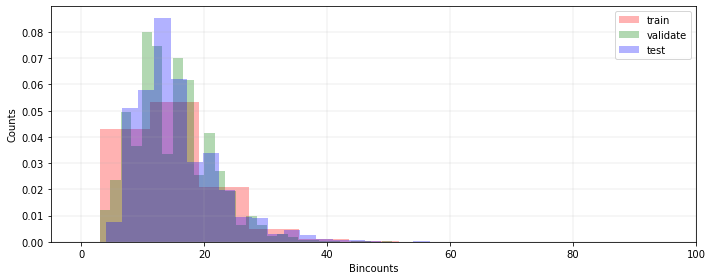

In [108]:
# tr_bin = get_hist(tr_ds)
# vl_bin = get_hist(vl_ds)
# ts_bin = get_hist(ts_ds)

plt.figure(figsize=(10, 4), facecolor="white")

plt.hist(tr_bin, color="r", alpha=.3, label="train", bins=30, density=True)
plt.hist(vl_bin, color="g", alpha=.3, label="validate", bins=30, density=True)
plt.hist(ts_bin, color="b", alpha=.3, label="test", bins=30, density=True)

plt.xlim([-5, 100])
plt.xlabel("Bincounts")
plt.ylabel("Counts")
plt.legend()
plt.grid(lw=.2)

plt.tight_layout()
plt.savefig("1.png")

In [127]:
for b in [tr_bin, vl_bin, ts_bin]:
    print(f"#: {len(b)}, ", end="")
    for threshold in [30, 50, 83, 100]:
        allowed = len(np.where(np.array(b) <= threshold)[0])
        print(f">{threshold}: {len(b)-allowed} ({(len(b)-allowed)/len(b)*100:.2f}%), ", end="")
    print()

#: 361185, >30: 10746 (2.98%), >50: 240 (0.07%), >83: 8 (0.00%), >100: 3 (0.00%), 
#: 40133, >30: 667 (1.66%), >50: 5 (0.01%), >83: 0 (0.00%), >100: 0 (0.00%), 
#: 4161, >30: 143 (3.44%), >50: 5 (0.12%), >83: 0 (0.00%), >100: 0 (0.00%), 


In [139]:
def get_hist2(ds):
    ans = []
    for i in tqdm(range(len(ds))):
        ans.append(ds[i]["tar_ext"].numpy())
    ans = np.sum(np.stack(ans, axis=0), axis=0)
    return ans

In [140]:
tr_bin = get_hist2(tr_ds)
vl_bin = get_hist2(vl_ds)
ts_bin = get_hist2(ts_ds)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4161/4161 [00:00<00:00, 16548.24it/s]


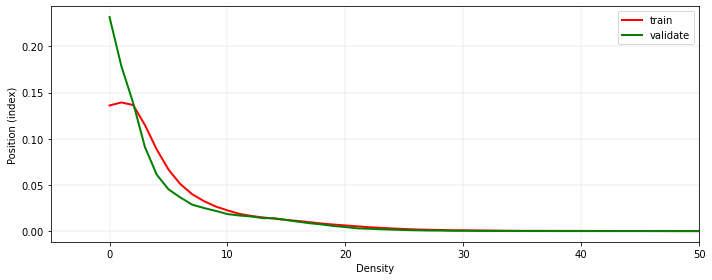

In [147]:
plt.figure(figsize=(10, 4), facecolor="white")

plt.plot(tr_bin / np.sum(tr_bin), color="r", lw=2, label="train")
plt.plot(vl_bin / np.sum(vl_bin), color="g", lw=2, label="validate")

plt.xlim([-5, 50])
plt.xlabel("Density")
plt.ylabel("Position (index)")
plt.legend()
plt.grid(lw=.2)

plt.tight_layout()
plt.savefig("1.png")

In [149]:
for b in [tr_bin, vl_bin, ts_bin]:
    print(f"#: {np.sum(b)}, ", end="")
    for threshold in [30, 50, 83, 100]:
        allowed = np.sum(np.array(b)[:threshold])
        print(f">{threshold}: {np.sum(b)-allowed} ({(np.sum(b)-allowed)/np.sum(b)*100:.2f}%), ", end="")
    print()

#: 1083555.0, >30: 5281.0 (0.49%), >50: 100.0 (0.01%), >83: 0.0 (0.00%), >100: 0.0 (0.00%), 
#: 120399.0, >30: 160.0 (0.13%), >50: 1.0 (0.00%), >83: 0.0 (0.00%), >100: 0.0 (0.00%), 
#: 12483, >30: 0 (0.00%), >50: 0 (0.00%), >83: 0 (0.00%), >100: 0 (0.00%), 


In [ ]:
# tr_ds[0]

## **Modeling**

In [ ]:
class KoBERTSumExt(torch.nn.Module):
    
    def __init__(
        self,
        d_model: int = args.d_model,
        nhead: int = args.nhead,
        dropout: float = args.dropout,
        num_layers: int = args.num_layers,
    ):
        super(KoBERTSumExt, self).__init__()
        ## Encoder.
        self.encoder = transformers.BertModel.from_pretrained(args.tokenizer_name)
        
        ## Decoder.
        self.d_model = d_model
        self.nhead = nhead
        self.dropout = dropout
        
        self.decoder = torch.nn.TransformerEncoder(
            encoder_layer=torch.nn.TransformerEncoderLayer(d_model=self.d_model, nhead=self.nhead, dropout=self.dropout),
            num_layers=self.num_layers,
        )
        
        ## Fully connected.
        self.fc = torch.nn.Linear(self.d_model, 1)
        self.pad_len = 2 ## ?

        
    def forward(self, inp, cls, seg, msk, msk_cls) -> torch.tensor:
        top_vec = self.encoder(
            input_ids=inp.long(), 
            attention_mask=msk.float(), ## bool -> float
            token_type_ids=seg.long(),
        ).last_hidden_state
        
        sents_vec = top_vec[torch.arange(top_vec.size(0)).unsqueeze(1), cls.long()]
        sents_vec = sents_vec * msk_cls[..., None].float() ## (batch, 83, d_model)
        
        
        top_vec = self.encoder(input_ids = x.long(), 
                               attention_mask = msk.float(), 
                               token_type_ids = seg.long()).last_hidden_state
        sents_vec = top_vec[torch.arange(top_vec.size(0)).unsqueeze(1), cls.long()]
        sents_vec = sents_vec * msk_cls[:, :, None].float() ## (batch, 50, 756)
        
        ## Put into transformer encoder after sentence padding.
        sent_scores = self.decoder(
            src = nn.functional.pad(sents_vec, (0, 0, 0, self.pad_len)).transpose(0, 1), 
            src_key_padding_mask = nn.functional.pad(msk_cls, (0, self.pad_len)),
        )
        
        ## Remove padded parts and do other works.
        sent_scores = self.fc(sent_scores.transpose(0, 1)[:, :-self.pad_len]).squeeze(-1)
        
        return sent_scores